In [1]:
import torch
from torch import nn
import torchvision
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import time
import xml.etree.ElementTree as ET
import glob
import random
import shutil
!pip install xmltodict
import xmltodict
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from timeit import default_timer as timer
from typing import Tuple, Dict, List
from PIL import Image
import torchvision
from matplotlib import patches
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_tensor
from matplotlib import patches
from torchvision.utils import make_grid
from torchvision.io import read_image
from tqdm.auto import tqdm
from PIL import Image
from xml.etree import ElementTree as ET
import torchvision.ops as ops
from torchvision.transforms import Compose
try:
    import torchmetrics, mlxtend
    assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 11.8 MB/s eta 0:00:00


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
rm -rf "/content/test"

In [4]:
rm -rf "/content/train"

In [5]:
from google.colab import drive
drive = drive.mount('/content/drive')
data_path = Path("data/")
if data_path.is_dir():
    print("Directory exists.")
else:
    data_path.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', "r") as zip_ref:
      print("Unzipping")
      zip_ref.extractall(data_path)

Mounted at /content/drive
Unzipping


In [6]:
input_data_path = '/content/data/images'
annotations_path = "/content/data/annotations"
images = [*os.listdir("/content/data/images")]
output_data_path =  '.'

In [7]:
def parse_and_extract(path):
    xml_tree = ET.parse(path)
    xml_root = xml_tree.getroot()
    common_info = {}
    object_elements = [child for child in xml_root if child.tag == 'object']
    for element in xml_tree.iter():
        if element.tag == 'filename':
            common_info['file_name'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    common_info['image_width'] = int(dim.text)
                if dim.tag == 'height':
                    common_info['image_height'] = int(dim.text)
                if dim.tag == 'depth':
                    common_info['image_depth'] = int(dim.text)
    object_params_list = [extract_annotation_info(obj) for obj in object_elements]
    combined_results = [merge_dicts(common_info, obj_info) for obj_info in object_params_list]
    return combined_results

In [8]:
def extract_annotation_info(annotation_element):
    info = {}
    for item in list(annotation_element):
        if item.tag == 'name':
            info['object_name'] = item.text
        if item.tag == 'bndbox':
            for coord in list(item):
                if coord.tag == 'xmin':
                    info['xmin'] = int(coord.text)
                if coord.tag == 'ymin':
                    info['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    info['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    info['ymax'] = int(coord.text)
    return info

In [9]:
def merge_dicts(dictionary1, dictionary2):
    result = {**dictionary1, **dictionary2}
    return result

In [10]:
dataset = [parse_and_extract(anno) for anno in glob.glob(annotations_path+"/*.xml") ]
full_dataset = sum(dataset, [])
df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [11]:
df["object_name"].value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: object_name, dtype: int64

In [12]:
labels = df['object_name'].unique()
directory = ['train', 'test']
output_data_path =  '.'
import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [13]:
def crop_image(image_path, left, top, right, bottom):
    x_shift = (right - left) * 0.1
    y_shift = (bottom - top) * 0.1
    img = Image.open(image_path)
    cropped_img = img.crop((left - x_shift, top - y_shift, right + x_shift, bottom + y_shift))
    return cropped_img

In [14]:
def extract_objects_from_image(image_filename, image_data):
    extracted_objects = []
    df_image = image_data[image_data['file_name'] == image_filename[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'object_name']]
    for index, row in df_image.iterrows():
        x_min, y_min, x_max, y_max, label = row
        image_path = os.path.join(input_data_path, image_filename)
        extracted_objects.append((crop_image(image_path, x_min, y_min, x_max, y_max), label, f'{image_filename[:-4]}_{(x_min, y_min)}'))
    return extracted_objects

In [15]:
cropFaces = [extract_objects_from_image(img, df) for img in images]

In [16]:
flattend_faces = sum(cropFaces, [])

In [17]:
with_mask = [(img, image_name) for img, label,image_name in flattend_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flattend_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flattend_faces if label == "without_mask"]

In [18]:
print(f'Number of images with mask: {len(with_mask)}')
print(f'Number of images without mask: {len(without_mask)}')
print(f'Number of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'Total: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

Number of images with mask: 3232
Number of images without mask: 717
Number of images incorrect mask: 123
Total: 4072


In [19]:
from sklearn.model_selection import train_test_split
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20)
train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20)
train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20)

In [20]:
print(len(train_with_mask),len(test_with_mask))

2585 647


In [21]:
def save_processed_image(processed_image, image_filename, output_directory, data_type, image_label):
    output_filepath = os.path.join(output_directory, data_type, image_label, f'{image_filename}.png')
    processed_image.save(output_filepath)

In [22]:
for image, image_name in train_with_mask:
    save_processed_image(image, image_name, output_data_path, 'train', 'with_mask')
for image, image_name in train_mask_weared_incorrect:
    save_processed_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')
for image, image_name in train_without_mask:
    save_processed_image(image, image_name, output_data_path, 'train', 'without_mask')
for image, image_name in test_with_mask:
    save_processed_image(image, image_name, output_data_path, 'test', 'with_mask')
for image, image_name in test_mask_weared_incorrect:
    save_processed_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')
for image, image_name in test_without_mask:
    save_processed_image(image, image_name, output_data_path, 'test', 'without_mask')

In [23]:
def delete_images_below_min_size(dataset_dir, min_width, min_height):
    for category in ['with_mask', 'mask_weared_incorrect', 'without_mask']:
        category_path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            with Image.open(img_path) as img:
                width, height = img.size
                if width < min_width and height < min_height:
                    os.remove(img_path)
                    print(f"Deleted {img_path} due to insufficient dimensions.")


In [24]:
train_dir = os.path.join(output_data_path, 'train')
test_dir = os.path.join(output_data_path, 'test')

min_width, min_height = 50, 50

delete_images_below_min_size(train_dir, min_width, min_height)
delete_images_below_min_size(test_dir, min_width, min_height)

Deleted ./train/with_mask/maksssksksss411_(321, 60).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss157_(368, 75).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss234_(341, 125).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss297_(50, 125).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss376_(191, 29).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss342_(103, 49).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss714_(78, 139).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss11_(249, 108).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss690_(170, 55).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss251_(155, 57).png due to insufficient dimensions.
Deleted ./train/with_mask/maksssksksss702_(379, 63).png due to insufficient dimensions.
Deleted ./train/with_mask/makss

In [25]:
batch_size=32
training_data = datasets.ImageFolder(root= "/content/train", transform = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))
training_data_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True,num_workers=os.cpu_count())
testing_data = datasets.ImageFolder(root= "/content/test", transform = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))
testing_data_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False,num_workers=os.cpu_count())

In [26]:
print(f'{len(training_data)} images belonging to {len(training_data.classes)} classes.')
print(f'{len(testing_data)} images belonging to {len(testing_data.classes)} classes.')

787 images belonging to 3 classes.
194 images belonging to 3 classes.


In [27]:
class_names = training_data.classes
print(class_names,training_data.class_to_idx)

['mask_weared_incorrect', 'with_mask', 'without_mask'] {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


In [28]:
class MaskClassifierCNN(nn.Module):
    def __init__(self):
        super(MaskClassifierCNN, self).__init__()
        self.network_architecture = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(87616, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        output = self.network_architecture(x)
        return output

In [29]:
def training_method(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    training_loss, training_accuracy = 0, 0
    for i, (images, targets) in enumerate(dataloader):
        images, targets = images.to(device), targets.to(device)
        targets_prediction = model(images)
        loss = loss_function(targets_prediction, targets)
        training_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        targets_predictions = torch.argmax(targets_prediction, dim=1)
        training_accuracy += (targets_predictions == targets).sum().item()/len(targets_prediction)
    training_loss = training_loss / len(dataloader)
    training_accuracy = training_accuracy / len(dataloader)
    return training_loss, training_accuracy

In [30]:
def testing_method(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_function: torch.nn.Module):
    model.eval()
    testing_loss, testing_accuracy = 0, 0
    with torch.inference_mode():
        for i, (images, targets) in enumerate(dataloader):
            images, targets = images.to(device), targets.to(device)
            targets_prediction = model(images)
            loss = loss_function(targets_prediction, targets)
            testing_loss += loss.item()
            targets_predictions = torch.argmax(targets_prediction, dim=1)
            testing_accuracy += ((targets_predictions == targets).sum().item()/len(targets_predictions))
    testing_loss = testing_loss / len(dataloader)
    testing_accuracy = testing_accuracy / len(dataloader)
    return testing_loss, testing_accuracy

In [31]:
def train_method(model: torch.nn.Module,
                 training_data_loader: torch.utils.data.DataLoader,
                 testing_data_loader: torch.utils.data.DataLoader,
                 optimizer: torch.optim.Optimizer,
                 loss_function: torch.nn.Module,
                 epochs: None):
  results = {"training_loss": [],"training_accuracy": [],"testing_loss": [],"testing_accuracy": []}
  for epoch in tqdm(range(epochs)):
      training_loss, training_accuracy = training_method(model=model,dataloader=training_data_loader,loss_function=loss_function,optimizer=optimizer)
      testing_loss, testing_accuracy = testing_method(model=model,dataloader=testing_data_loader,loss_function=loss_function)
      print(f"For Epoch: {epoch+1} | "f"training_loss: {training_loss} | "f"training_accuracy: {training_accuracy} | "f"testing_loss: {testing_loss} | "f"testing_accuracy: {testing_accuracy}")
      results["training_loss"].append(training_loss)
      results["training_accuracy"].append(training_accuracy)
      results["testing_loss"].append(testing_loss)
      results["testing_accuracy"].append(testing_accuracy)
  return results

In [32]:
def loss_accuracy_plot(results: Dict[str, List[float]]):
    training_loss = results['training_loss']
    testing_loss = results['testing_loss']
    training_accuracy = results['training_accuracy']
    testing_accuracy = results['testing_accuracy']
    epochs = range(len(results['training_loss']))
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='training_loss')
    plt.plot(epochs, testing_loss, label='testing_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label='training_accuracy')
    plt.plot(epochs, testing_accuracy, label='testing_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [33]:
def plot_image(model: torch.nn.Module,
               image_path: str,
               class_names: List[str] = None,
               transform=None,
               device: torch.device = torch.device('cpu')):
    image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    image = image / 255.
    if transform:
        image = transform(image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        image = image.unsqueeze(dim=0)
        image_prediction = model(image.to(device))
    image_prediction_probability = torch.softmax(image_prediction, dim=1)
    image_prediction_label = torch.argmax(image_prediction, dim=1)
    plt.imshow(image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[image_prediction_label.cpu()]} | Prob: {image_prediction_probability.max().cpu()}"
    else:
        title = f"Pred: {image_prediction_label} | Prob: {image_prediction_probability.max().cpu()}"
    plt.title(title)
    plt.axis(False)

In [34]:
custom_image_transform = transforms.Compose([
    transforms.Resize((150, 150)),
])

In [ ]:
#summary(model1, input_size=[1, 3, 150, 150])

Layer (type:depth-idx)                   Output Shape              Param #
MaskClassifierCNN                        [1, 3]                    --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Conv2d: 2-1                       [1, 16, 150, 150]         448
│    └─ReLU: 2-2                         [1, 16, 150, 150]         --
│    └─MaxPool2d: 2-3                    [1, 16, 75, 75]           --
│    └─Conv2d: 2-4                       [1, 32, 75, 75]           4,640
│    └─ReLU: 2-5                         [1, 32, 75, 75]           --
│    └─MaxPool2d: 2-6                    [1, 32, 37, 37]           --
│    └─Conv2d: 2-7                       [1, 64, 37, 37]           18,496
│    └─ReLU: 2-8                         [1, 64, 37, 37]           --
│    └─Flatten: 2-9                      [1, 87616]                --
│    └─Linear: 2-10                      [1, 64]                   5,607,488
│    └─ReLU: 2-11                        [1, 64]                   --


In [ ]:
epochs = 30
model1 = MaskClassifierCNN().to(device)
loss_function = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model1.parameters(),lr=0.0001,amsgrad=True)
start_time = timer()
model1_plot = train_method(model=model1,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 0.6859946864843368 | training_accuracy: 0.81875 | testing_loss: 0.6431245761258262 | testing_accuracy: 0.7857142857142857
For Epoch: 2 | training_loss: 0.6009895622730255 | training_accuracy: 0.825 | testing_loss: 0.6207305192947388 | testing_accuracy: 0.7857142857142857
For Epoch: 3 | training_loss: 0.5904596602916717 | training_accuracy: 0.78625 | testing_loss: 0.5906009120600564 | testing_accuracy: 0.7857142857142857
For Epoch: 4 | training_loss: 0.49224591910839083 | training_accuracy: 0.825 | testing_loss: 0.577022138450827 | testing_accuracy: 0.7857142857142857
For Epoch: 5 | training_loss: 0.4503436499834061 | training_accuracy: 0.82625 | testing_loss: 0.5318481677344867 | testing_accuracy: 0.7857142857142857
For Epoch: 6 | training_loss: 0.43200676679611205 | training_accuracy: 0.83875 | testing_loss: 0.49622087606361936 | testing_accuracy: 0.7857142857142857
For Epoch: 7 | training_loss: 0.4025367391109467 | training_accuracy: 0.84625 | testing_lo

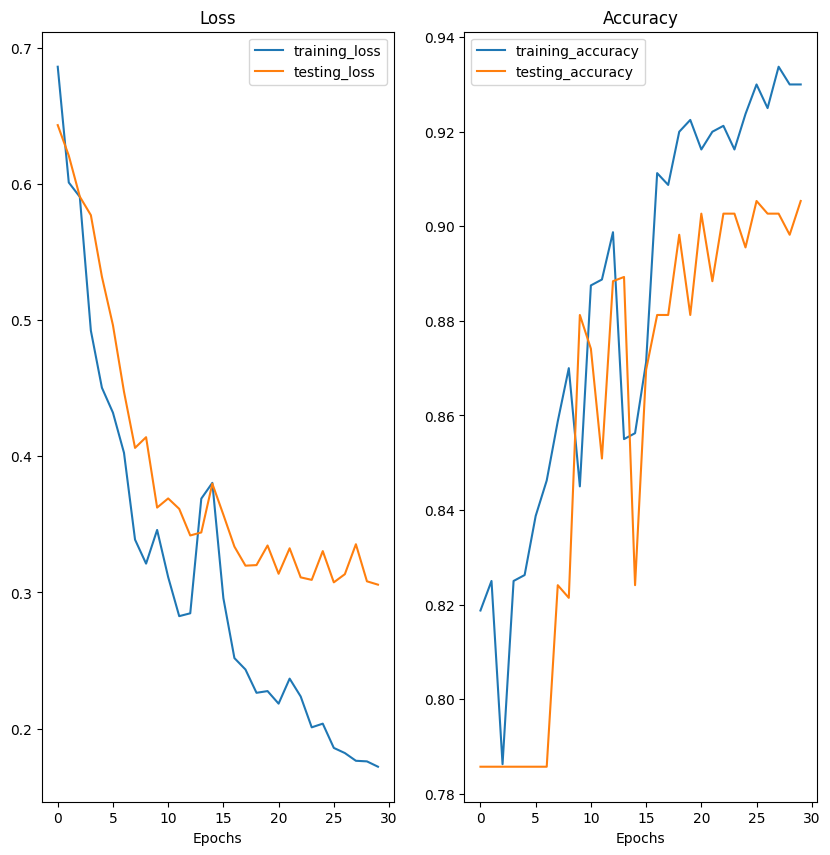

In [ ]:
loss_accuracy_plot(model1_plot)

0it [00:00, ?it/s]

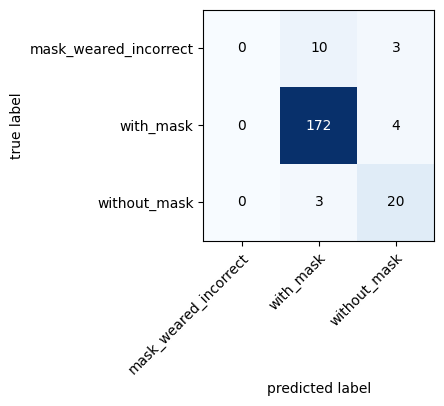

In [ ]:
model1.eval()
targets_prediction = []
with torch.no_grad():
    for i, (images, targets) in tqdm(enumerate(testing_data_loader)):
        images, targets = images.to(device), targets.to(device)
        testing_predictions = model1(images)
        testing_predictions_labels = testing_predictions.argmax(dim=1)
        targets_prediction.append(testing_predictions_labels.cpu())
targets_prediction_tensor = torch.cat(targets_prediction).squeeze()

confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_matrix_tensor = confusion_matrix(targets_prediction_tensor, torch.tensor(testing_data.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=np.array(confusion_matrix_tensor),
    class_names=class_names,
    figsize=(3, 3)
)

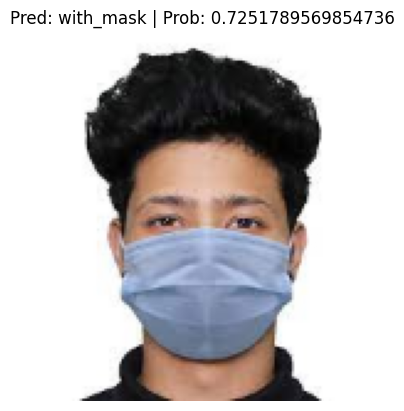

In [ ]:
plot_image(model=model1,
          image_path="/content/download (2).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

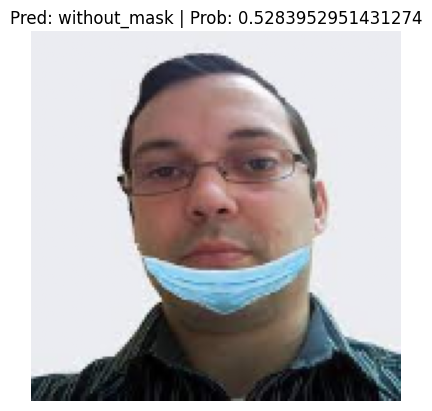

In [ ]:
plot_image(model=model1,
          image_path="/content/download (3).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

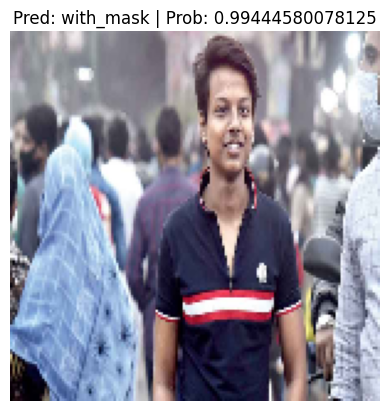

In [ ]:
plot_image(model=model1,
          image_path="/content/1643146778_26metsks-nomask11_4c.jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

In [35]:
epochs = 30
model2 = MaskClassifierCNN().to(device)
loss_function = nn.CrossEntropyLoss()
model_optimizer = torch.optim.SGD(model2.parameters(),lr=0.001,momentum=0.995,weight_decay=0.1)
start_time = timer()
model2_plot = train_method(model=model2,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 0.8228056907653809 | training_accuracy: 0.7082236842105263 | testing_loss: 1.2352300677448511 | testing_accuracy: 0.7142857142857143
For Epoch: 2 | training_loss: 0.7424469435214996 | training_accuracy: 0.8195394736842105 | testing_loss: 0.7711048126220703 | testing_accuracy: 0.7142857142857143
For Epoch: 3 | training_loss: 0.6641061544418335 | training_accuracy: 0.8186842105263158 | testing_loss: 0.8776961288281849 | testing_accuracy: 0.7142857142857143
For Epoch: 4 | training_loss: 0.6339729070663452 | training_accuracy: 0.8186842105263158 | testing_loss: 0.7544285484722683 | testing_accuracy: 0.7142857142857143
For Epoch: 5 | training_loss: 0.607553209066391 | training_accuracy: 0.8195394736842105 | testing_loss: 0.880243755877018 | testing_accuracy: 0.7142857142857143
For Epoch: 6 | training_loss: 0.5915713918209076 | training_accuracy: 0.8195394736842105 | testing_loss: 0.7864359787532261 | testing_accuracy: 0.7142857142857143
For Epoch: 7 | training_

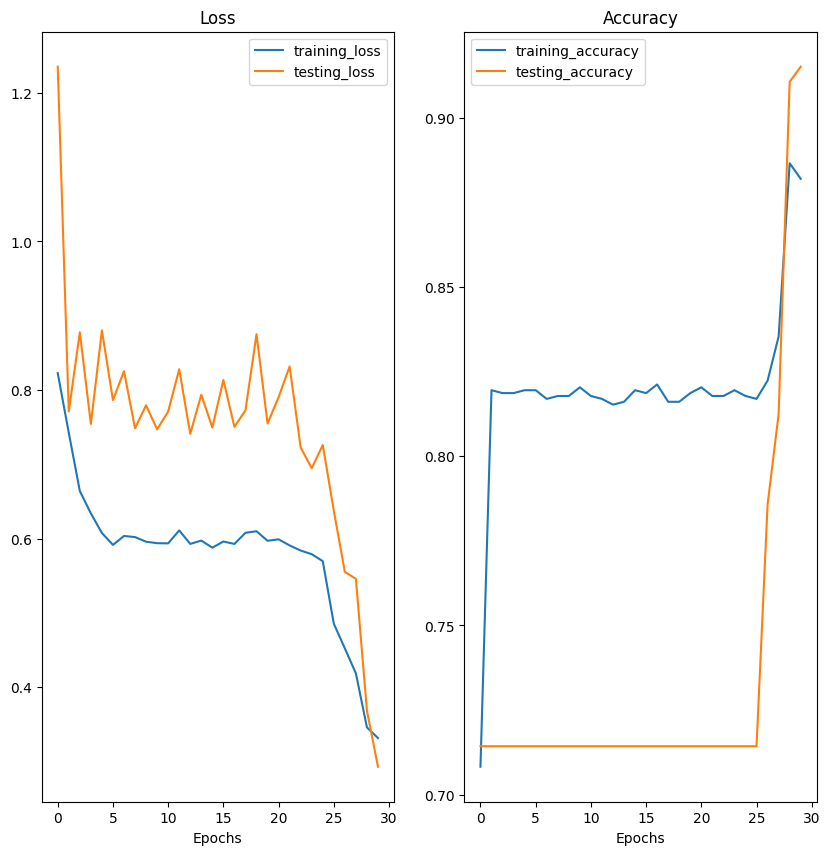

In [36]:
loss_accuracy_plot(model2_plot)

0it [00:00, ?it/s]

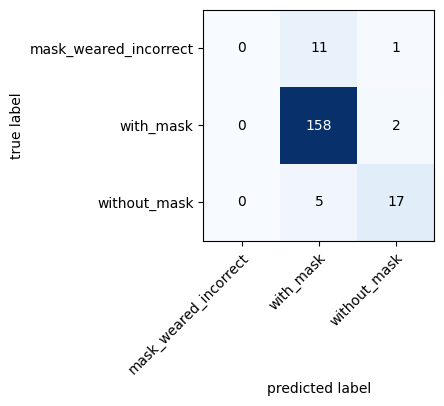

In [37]:
model2.eval()
targets_prediction = []
with torch.no_grad():
    for i, (images, targets) in tqdm(enumerate(testing_data_loader)):
        images, targets = images.to(device), targets.to(device)
        testing_predictions = model2(images)
        testing_predictions_labels = testing_predictions.argmax(dim=1)
        targets_prediction.append(testing_predictions_labels.cpu())
targets_prediction_tensor = torch.cat(targets_prediction).squeeze()

confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_matrix_tensor = confusion_matrix(targets_prediction_tensor, torch.tensor(testing_data.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=np.array(confusion_matrix_tensor),
    class_names=class_names,
    figsize=(3, 3)
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


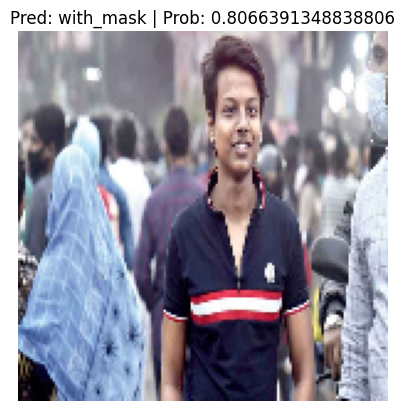

In [40]:
plot_image(model=model2,
          image_path="/content/1643146778_26metsks-nomask11_4c.jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

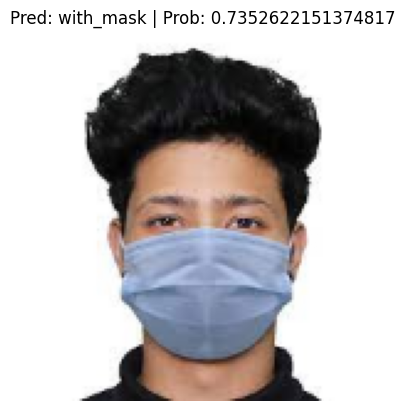

In [41]:
plot_image(model=model2,
          image_path="/content/download (2).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

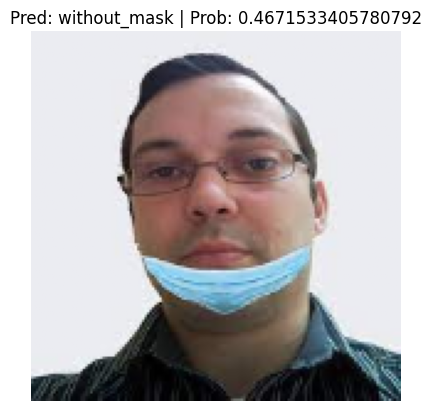

In [42]:
plot_image(model=model2,
          image_path="/content/download (3).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

# VGG16

In [43]:
class MaskClassificationVGG(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskClassificationVGG, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [44]:
#summary(model3, input_size=[1, 3, 150, 150])

In [45]:
epochs = 30
model3 = MaskClassificationVGG().to(device)
loss_function = nn.CrossEntropyLoss()
model_optimizer = torch.optim.SGD(model3.parameters(),lr=0.0001,momentum=0.995,weight_decay=0.1)
start_time = timer()
model3_plot = train_method(model=model3,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 0.7945192468166351 | training_accuracy: 0.7115789473684211 | testing_loss: 0.8243186133248466 | testing_accuracy: 0.7142857142857143
For Epoch: 2 | training_loss: 0.7838320791721344 | training_accuracy: 0.817828947368421 | testing_loss: 0.7052463463374546 | testing_accuracy: 0.7142857142857143
For Epoch: 3 | training_loss: 0.5815273952484131 | training_accuracy: 0.817828947368421 | testing_loss: 0.7708163942609515 | testing_accuracy: 0.7142857142857143
For Epoch: 4 | training_loss: 0.6259401988983154 | training_accuracy: 0.817828947368421 | testing_loss: 0.7598226155553546 | testing_accuracy: 0.7366071428571429
For Epoch: 5 | training_loss: 0.5085930329561233 | training_accuracy: 0.8203947368421052 | testing_loss: 0.6900358881269183 | testing_accuracy: 0.7142857142857143
For Epoch: 6 | training_loss: 0.45270483314990995 | training_accuracy: 0.8169736842105263 | testing_loss: 0.6593080375875745 | testing_accuracy: 0.7142857142857143
For Epoch: 7 | training_

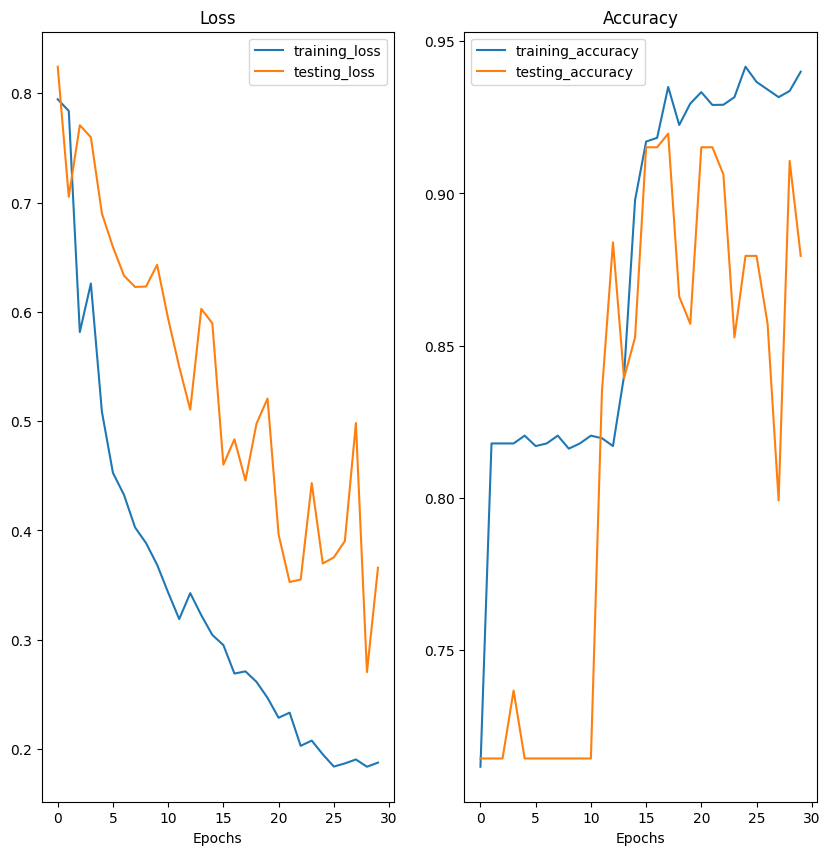

In [46]:
loss_accuracy_plot(model3_plot)

0it [00:00, ?it/s]

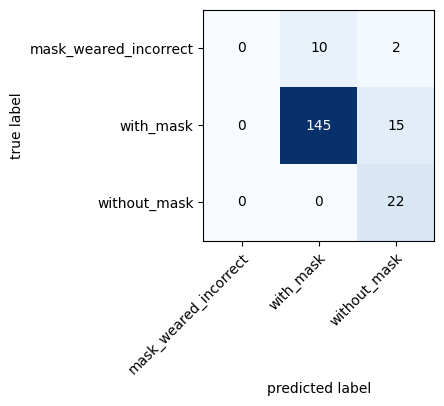

In [47]:
model3.eval()
targets_prediction = []
with torch.no_grad():
    for i, (images, targets) in tqdm(enumerate(testing_data_loader)):
        images, targets = images.to(device), targets.to(device)
        testing_predictions = model3(images)
        testing_predictions_labels = testing_predictions.argmax(dim=1)
        targets_prediction.append(testing_predictions_labels.cpu())
targets_prediction_tensor = torch.cat(targets_prediction).squeeze()

confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_matrix_tensor = confusion_matrix(targets_prediction_tensor, torch.tensor(testing_data.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=np.array(confusion_matrix_tensor),
    class_names=class_names,
    figsize=(3, 3)
)

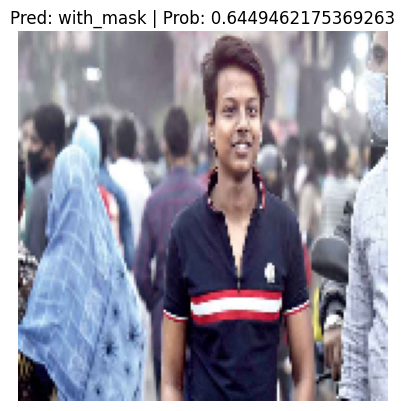

In [48]:
plot_image(model=model3,
          image_path="/content/1643146778_26metsks-nomask11_4c.jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

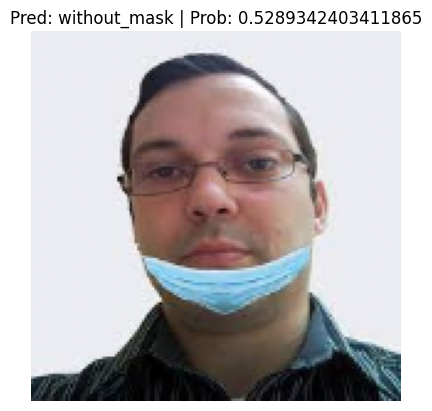

In [49]:
plot_image(model=model3,
          image_path="/content/download (3).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

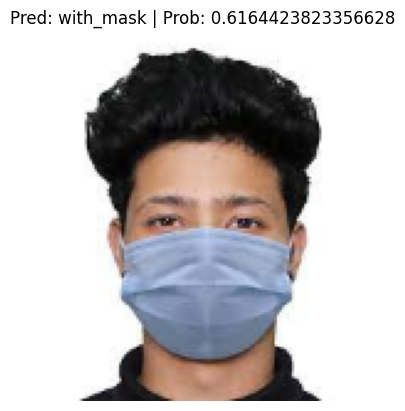

In [50]:
plot_image(model=model3,
          image_path="/content/download (2).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

In [51]:
epochs = 30
model4 = MaskClassificationVGG().to(device)
loss_function = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model4.parameters(), lr=0.00001, amsgrad=True)
start_time = timer()
model4_plot = train_method(model=model4,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 0.6188978445529938 | training_accuracy: 0.8020394736842106 | testing_loss: 0.8745339342526027 | testing_accuracy: 0.7142857142857143
For Epoch: 2 | training_loss: 0.4702808254957199 | training_accuracy: 0.8186842105263158 | testing_loss: 0.6222932296139854 | testing_accuracy: 0.7142857142857143
For Epoch: 3 | training_loss: 0.3738835394382477 | training_accuracy: 0.8428947368421053 | testing_loss: 0.36913576828581945 | testing_accuracy: 0.8660714285714286
For Epoch: 4 | training_loss: 0.30370612621307375 | training_accuracy: 0.8999342105263157 | testing_loss: 0.27142863454563276 | testing_accuracy: 0.9419642857142857
For Epoch: 5 | training_loss: 0.23966322362422943 | training_accuracy: 0.9178289473684211 | testing_loss: 0.22668164063777244 | testing_accuracy: 0.9419642857142857
For Epoch: 6 | training_loss: 0.1950985862314701 | training_accuracy: 0.9341447368421052 | testing_loss: 0.21624253543892077 | testing_accuracy: 0.9419642857142857
For Epoch: 7 | t

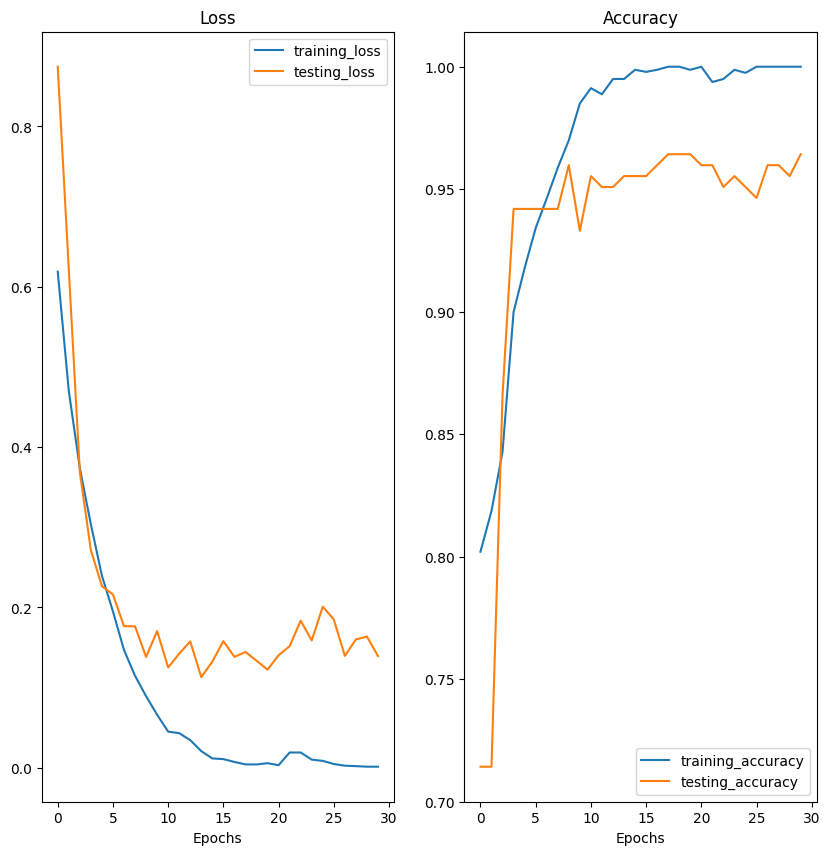

In [52]:
loss_accuracy_plot(model4_plot)

0it [00:00, ?it/s]

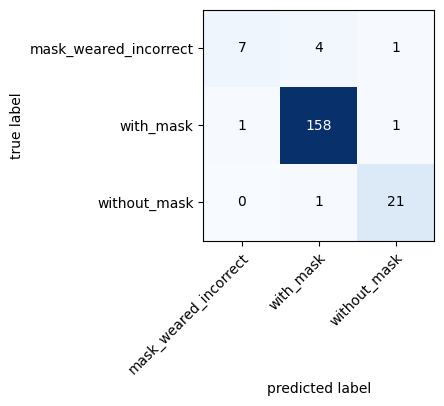

In [53]:
model4.eval()
targets_prediction = []
with torch.no_grad():
    for i, (images, targets) in tqdm(enumerate(testing_data_loader)):
        images, targets = images.to(device), targets.to(device)
        testing_predictions = model4(images)
        testing_predictions_labels = testing_predictions.argmax(dim=1)
        targets_prediction.append(testing_predictions_labels.cpu())
targets_prediction_tensor = torch.cat(targets_prediction).squeeze()
confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_matrix_tensor = confusion_matrix(targets_prediction_tensor, torch.tensor(testing_data.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=np.array(confusion_matrix_tensor),
    class_names=class_names,
    figsize=(3, 3)
)

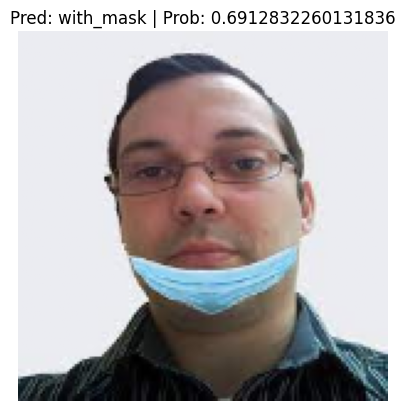

In [75]:
plot_image(model=model4,
          image_path="/content/download (3).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

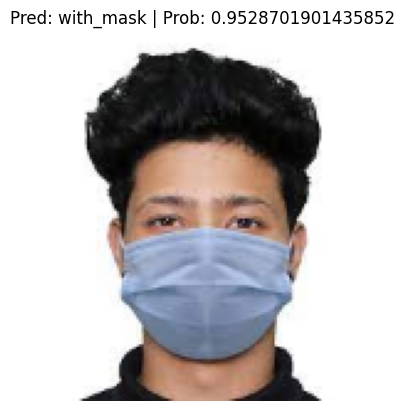

In [76]:
plot_image(model=model4,
          image_path="/content/download (2).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

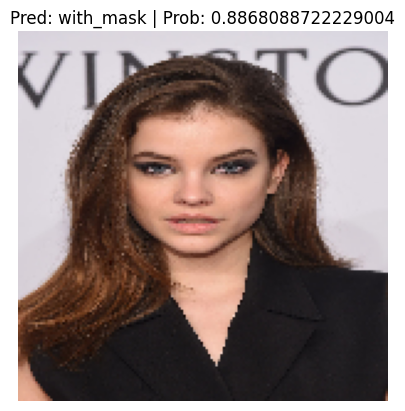

In [79]:
plot_image(model=model4,
          image_path="/content/licensed-image (1).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

In [57]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.0 MB/s eta 0:

In [58]:
model4.to("cpu")
next(iter(model4.parameters())).device

device(type='cpu')

In [59]:
def predict(img) -> Tuple[Dict, float]:
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    tensor = transform(img)
    tensor = tensor.unsqueeze(0)

    start_time = timer()
    model4.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(model4(tensor), dim=1)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    pred_time = round(timer() - start_time, 5)
    return pred_labels_and_probs, pred_time


image = Image.open("/content/download (2).jpg")

pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

Prediction label and probability dictionary: 
{'mask_weared_incorrect': 1.7713914636665523e-31, 'with_mask': 1.0, 'without_mask': 0.0}
Prediction time: 0.13867 seconds


In [60]:
import gradio as gr
title = "Mask detection"
description = "Classify mask wearing"
article = "Created by team 12"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    title=title,
                    description=description,
                    article=article)
demo.launch(debug=True,
            share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c131313290bcf4c9dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c131313290bcf4c9dc.gradio.live


In [73]:
import glob
directory = "/content/train/without_mask"
image_paths = glob.glob(directory + '/**/*.jpg', recursive=True)
image_paths += glob.glob(directory + '/**/*.png', recursive=True)
num_images = len(image_paths)
print(f"Number of images: {num_images}")
directory = "/content/train/with_mask"
image_paths = glob.glob(directory + '/**/*.jpg', recursive=True)
image_paths += glob.glob(directory + '/**/*.png', recursive=True)
num_images = len(image_paths)
print(f"Number of images: {num_images}")
directory = "/content/train/mask_weared_incorrect"
image_paths = glob.glob(directory + '/**/*.jpg', recursive=True)
image_paths += glob.glob(directory + '/**/*.png', recursive=True)
num_images = len(image_paths)
print(f"Number of images: {num_images}")

Number of images: 660
Number of images: 644
Number of images: 627


In [74]:
import os
import uuid
from PIL import Image
from imgaug import augmenters as iaa
import numpy as np
def augment_images(directory, augmentations_per_image=5):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Crop(percent=(0, 0.1)),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True)
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = Image.open(os.path.join(directory, filename))
            img = np.array(img)
            for _ in range(augmentations_per_image):
                img_aug = seq(image=img)
                img_aug = Image.fromarray(img_aug).convert('RGB')
                img_aug.save(os.path.join(directory, str(uuid.uuid4()) + '.jpg'))


In [63]:
augment_images("/content/train/without_mask",5)

In [64]:
augment_images("/content/train/mask_weared_incorrect",18)

In [65]:
directory = "/content/train/without_mask"
image_paths = glob.glob(directory + '/**/*.jpg', recursive=True)
image_paths += glob.glob(directory + '/**/*.png', recursive=True)
num_images = len(image_paths)

print(f"Number of images: {num_images}")
directory = "/content/train/with_mask"
image_paths = glob.glob(directory + '/**/*.jpg', recursive=True)
image_paths += glob.glob(directory + '/**/*.png', recursive=True)
num_images = len(image_paths)

print(f"Number of images: {num_images}")
directory = "/content/train/mask_weared_incorrect"
image_paths = glob.glob(directory + '/**/*.jpg', recursive=True)
image_paths += glob.glob(directory + '/**/*.png', recursive=True)
num_images = len(image_paths)

print(f"Number of images: {num_images}")

Number of images: 660
Number of images: 644
Number of images: 627


In [66]:
batch_size=32
train_data = datasets.ImageFolder(root= "/content/train", transform = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,num_workers=os.cpu_count())

test_data = datasets.ImageFolder(root= "/content/test", transform = transforms.Compose([transforms.Resize((150,150)),transforms.ToTensor()]))
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False,num_workers=os.cpu_count())

In [80]:
epochs = 30
model5 = MaskClassificationVGG().to(device)
loss_function = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model5.parameters(), lr=0.00001, amsgrad=True)
start_time = timer()
model5_plot = train_method(model=model5,
                           training_data_loader=training_data_loader,
                           testing_data_loader=testing_data_loader,
                           optimizer=model_optimizer,
                           loss_function=loss_function,
                           epochs=epochs)
end_time = timer()
print(f"Total training time for model training and testing: {end_time-start_time} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch: 1 | training_loss: 0.6322710847854615 | training_accuracy: 0.7911842105263157 | testing_loss: 0.893436210496085 | testing_accuracy: 0.7142857142857143
For Epoch: 2 | training_loss: 0.5008960378170013 | training_accuracy: 0.8161184210526317 | testing_loss: 0.6510054383959089 | testing_accuracy: 0.7142857142857143
For Epoch: 3 | training_loss: 0.39928142189979554 | training_accuracy: 0.8349342105263158 | testing_loss: 0.43743965455463957 | testing_accuracy: 0.8616071428571429
For Epoch: 4 | training_loss: 0.30812763452529907 | training_accuracy: 0.8991447368421052 | testing_loss: 0.27877521940640043 | testing_accuracy: 0.9375
For Epoch: 5 | training_loss: 0.23582323372364045 | training_accuracy: 0.93 | testing_loss: 0.24033843779138156 | testing_accuracy: 0.9330357142857143
For Epoch: 6 | training_loss: 0.1904948553442955 | training_accuracy: 0.94125 | testing_loss: 0.19922177573399885 | testing_accuracy: 0.9330357142857143
For Epoch: 7 | training_loss: 0.1594010654091835 | tr

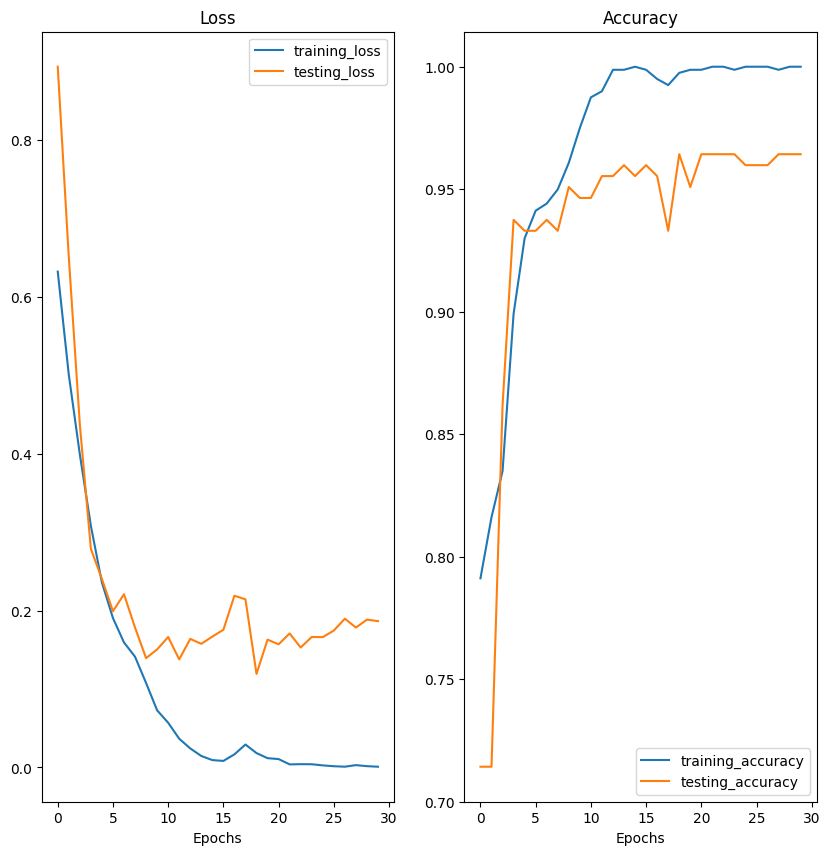

In [81]:
loss_accuracy_plot(model5_plot)

0it [00:00, ?it/s]

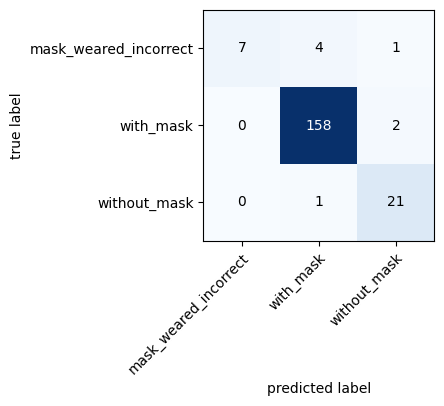

In [82]:
model5.eval()
targets_prediction = []
with torch.no_grad():
    for i, (images, targets) in tqdm(enumerate(testing_data_loader)):
        images, targets = images.to(device), targets.to(device)
        testing_predictions = model5(images)
        testing_predictions_labels = testing_predictions.argmax(dim=1)
        targets_prediction.append(testing_predictions_labels.cpu())
targets_prediction_tensor = torch.cat(targets_prediction).squeeze()
confusion_matrix = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confusion_matrix_tensor = confusion_matrix(targets_prediction_tensor, torch.tensor(testing_data.targets))
fig, ax = plot_confusion_matrix(
    conf_mat=np.array(confusion_matrix_tensor),
    class_names=class_names,
    figsize=(3, 3)
)

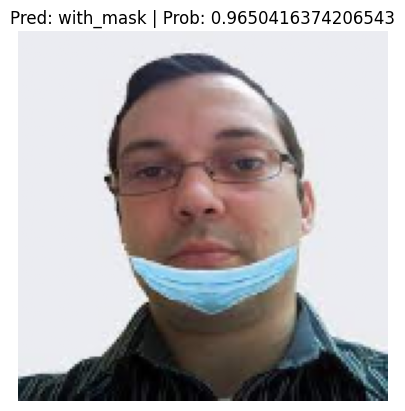

In [86]:
plot_image(model=model5,
          image_path="/content/download (3).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

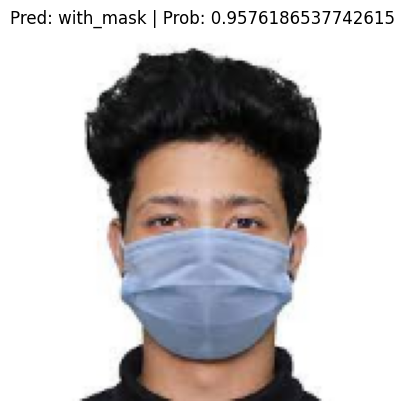

In [87]:
plot_image(model=model5,
          image_path="/content/download (2).jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

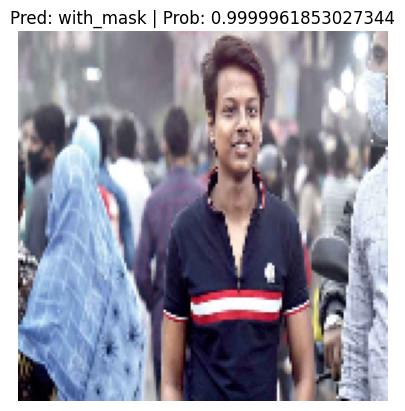

In [88]:
plot_image(model=model5,
          image_path="/content/1643146778_26metsks-nomask11_4c.jpg",
          class_names=class_names,
          transform=custom_image_transform,
          device=device)

References:
https://www.learnpytorch.io/
https://imgaug.readthedocs.io/en/latest/source/examples_basics.html
https://www.kaggle.com/code/sandhyakrishnan02/face-mask-detection-using-pytorch